# Random Forest Model For Predicting First Day IPO Performance

This notebook trains and tests a random forest model to predict whether an IPO (Inital Public Offering) will be underpriced or not.

To begin, we will import the necessary modules and libraries

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import pickle
# visualizaitions
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

import itertools
import os
import numpy as np
import matplotlib.pyplot as plt


We first read the ipo data from a csv to a pandas data frame.

After collecting the labels for the data points, we select all numeric features so that it can be processed in the random forest model. We store the labels of the features we choose to use in `ipo_features`.



In [5]:
# load dataset
ipos = pd.read_csv("../data/clean_bloomberg_with_sectors_macro.csv")
# get labels
ipo_labels = ipos["Underpriced"].tolist()
# get features
ipos = ipos.select_dtypes(['float64', 'float32', int])
ipo_features = ipos._get_numeric_data().columns.values.tolist()[1:-1]
# remove feature wich defines the label
ipo_features.remove('Offer To 1st Close')
# TODO remove these features from the csv
ipo_features.remove('Shares Outstanding (M).1')
ipo_features.remove('Offer Size (M).1')
print("Possible Features:", ipo_features)

Possible Features: ['Profit Margin', 'Return on Assets', 'Offer Size (M)', 'Shares Outstanding (M)', 'Offer Price', 'Market Cap at Offer (M)', 'Cash Flow per Share', 'Instit Owner (% Shares Out)', 'Instit Owner (Shares Held)', 'Real GDP Per Capita', 'OECD Leading Indicator', 'Interest Rate', 'Seasonally Adjusted Unemployment Rate', 'CPI Growth Rate', 'Industry Sector', 'Industry Group', 'Industry Subgroup']


The features we have chose to use are stored in `ipo_features_data` as a pandas dataframe. Using this data frame long with the labels, we make a test and training split. 

We then use `sci-kit learn`'s Random Forest model to initialize a classification model. This model is trained on the designated training data we have created. We then make a prediction by feeding the newly created model the test set we created.

Random forest is an ensemble machine learning algorithm that uses multiple decision trees to make predictions. It works by randomly selecting a subset of features from the dataset and then building a decision tree for each subset. This is process is called bagging. Each tree is then used to make a prediction, and the final prediction is made by taking the average of all the individual tree predictions. Bagging along with with the other processes helps reduce overfitting and improves accuracy. Random forest also has the ability to handle large datasets with high dimensionality, making it a powerful tool for predictive analytics.

In [6]:
# get columns for specified features
ipo_features = ipo_features[:-1]
ipo_features_data = ipos[ipo_features]
# split dataset to trianing set and test set
ipo_features_data_train, ipo_features_data_test, ipo_labels_train, ipo_labels_test = train_test_split(ipo_features_data, ipo_labels, test_size=0.3)
# create classifier 
clf = RandomForestClassifier(n_estimators=200)
# train the model
clf.fit(ipo_features_data_train, ipo_labels_train)
# predict
ipo_labels_pred = clf.predict(ipo_features_data_test)
# save the trained model
with open('saved_models/random_forest_bloomberg_total.pkl', 'wb') as file :
    pickle.dump(clf, file)

In [17]:
# create random forest models with various parameters
def create_model(name, n_estimators, criterion, max_depth, bootstrap) :
    model = RandomForestClassifier(n_estimators=n_estimators, criterion=criterion, max_depth=max_depth, bootstrap=bootstrap)
    model.fit(ipo_features_data_train, ipo_labels_train)
    with open('saved_models/random_forest/' + name + ".pkl", 'wb') as file :
        pickle.dump(model, file)

# possible parameters
"""
estimators = [x for x in range(100, 1000, 50)]
criterion = ["gini", "entropy"]
max_depth = [x for x in range(1, len(ipo_features))]
bootstrap = [True, False]
params = [estimators, criterion, max_depth, bootstrap]

# make models witha permutation of parameters
name = "random_forest_"
s = list(itertools.product(*params))
for i in range(len(s)) :
    n_estimators, criterion, max_depth, bootstrap = s[i]
    create_model(name + str(i), n_estimators, criterion, max_depth, bootstrap)
"""

In [23]:
# evaluates the models 
def eval_model(model) :
    ipo_labels_pred = model.predict(ipo_features_data_test)
    accuracy = metrics.accuracy_score(ipo_labels_test, ipo_labels_pred)
    return accuracy

# Load each model and store it in a dictionary
# pkl_models = []

# dir_path = "saved_models/random_forest"

# for file in os.listdir(dir_path):
#     with open(os.path.join(dir_path, file), "rb") as f:
#         model = pickle.load(f)
#         # Use the loaded model for predictions or other operations
#         pkl_models.append((os.path.splitext(file)[0], model))


model_accuracies = {}
# best model 
best_accuracy = -1.0
best_model_name = ""
best_model_params = {}
# worst model 
worst_accuracy = 1.1
worst_model_name = ""
worst_model_params = {}
# find the best and worst
for model_name, model in pkl_models :
    model_accuracy = eval_model(model)
    model_accuracies[model_name] = model_accuracy
    if best_accuracy < model_accuracy :
        best_accuracy = model_accuracy
        best_model_name = model_name
        best_model_params = model.get_params(True)
    elif worst_accuracy > model_accuracy :
        worst_accuracy = model_accuracy
        worst_model_name = model_name
        worst_model_params = model.get_params(True)

In [26]:
# select the one witht he best accuracy 
print("Model " + best_model_name + " had the best accuracy with a score of", best_accuracy )
print("Best model params:", best_model_params)
print()
print("Model " + worst_model_name + " had the worst accuracy with a score of", worst_accuracy)
print("Worst model params: ", worst_model_params)

Model random_forest_55 had the best accuracy with a score of 0.9333333333333333
Best model params: {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 13, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}

Model random_forest_963 had the worst accuracy with a score of 0.7372549019607844
Worst model params:  {'bootstrap': False, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 900, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [9]:
model_accuracies

{'random_forest_977': 0.8764705882352941,
 'random_forest_963': 0.7372549019607844,
 'random_forest_793': 0.8294117647058824,
 'random_forest_787': 0.7490196078431373,
 'random_forest_778': 0.9313725490196079,
 'random_forest_988': 0.9274509803921569,
 'random_forest_750': 0.7372549019607844,
 'random_forest_744': 0.9274509803921569,
 'random_forest_93': 0.7372549019607844,
 'random_forest_591': 0.9215686274509803,
 'random_forest_585': 0.8392156862745098,
 'random_forest_87': 0.9294117647058824,
 'random_forest_1031': 0.807843137254902,
 'random_forest_208': 0.9294117647058824,
 'random_forest_78': 0.8764705882352941,
 'random_forest_1025': 0.7392156862745098,
 'random_forest_50': 0.8960784313725491,
 'random_forest_234': 0.9274509803921569,
 'random_forest_552': 0.8176470588235294,
 'random_forest_546': 0.7470588235294118,
 'random_forest_1019': 0.9274509803921569,
 'random_forest_220': 0.7764705882352941,
 'random_forest_44': 0.8313725490196079,
 'random_forest_383': 0.9254901960784

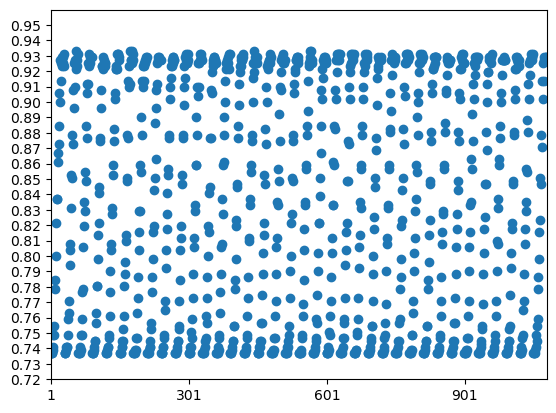

In [22]:
model_nums = list(map(lambda x: int(x[14:]), list(model_accuracies.keys()))) # truncate
values = list(model_accuracies.values())
fig, ax = plt.subplots()
ax.scatter(model_nums, values)
ax.set(ylim=(0.72, 0.96), yticks=np.arange(0.72, 0.96, 0.01), xlim=(0, 1079), xticks=np.arange(1, 1079, 300))
plt.show()

We now analyze the importance of each feature.

In [35]:
# find feature importance
best_model_path = "saved_models/random_forest/" + best_model_name + ".pkl"

with open(best_model_path, "rb") as f:
    best_model = pickle.load(f)

best_feature_imp = pd.Series(best_model.feature_importances_,index=[ipo_features]).sort_values(ascending=False)
print("best model feature importance:\n", best_feature_imp)

print()
worst_model_path = "saved_models/random_forest/" + worst_model_name + ".pkl"
with open(worst_model_path, "rb") as f:
    worst_model = pickle.load(f)

worst_feature_imp = pd.Series(worst_model.feature_importances_,index=[ipo_features]).sort_values(ascending=False)
print("worst model feature importance:\n", worst_feature_imp)

best model feature importance:
 Market Cap at Offer (M)                  0.080829
Return on Assets                         0.079449
Instit Owner (% Shares Out)              0.078085
Profit Margin                            0.078044
Cash Flow per Share                      0.073666
Offer Size (M)                           0.073289
Instit Owner (Shares Held)               0.070684
Shares Outstanding (M)                   0.068968
Offer Price                              0.064215
CPI Growth Rate                          0.062999
Industry Group                           0.057847
Seasonally Adjusted Unemployment Rate    0.054051
OECD Leading Indicator                   0.053837
Real GDP Per Capita                      0.050015
Interest Rate                            0.030329
Industry Sector                          0.023694
dtype: float64

worst model feature importance:
 Market Cap at Offer (M)                  0.239955
Offer Price                              0.130528
Instit Owner (% Sha

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [ ]:
estimator = clf.estimators_[10]

In [ ]:
export_graphviz(estimator, out_file='small_tree.dot', 
                feature_names = ['Offer Price', 'Opening Price'],
                #class_names = clf.target_names,
                rounded = True, proportion = False, 
                precision = 1, filled = True)

In [ ]:
call(['dot', '-Tpng', 'small_tree.dot', '-o', 'small_tree.png', '-Gdpi=600'])

In [ ]:
Image(filename = 'small_tree.png')